# Homework 3

Your name:lingzhi ma

Your Andrew ID:lingzhim

Collaborators (if none, say \"none\"; do *not* leave this blank): none

# Part 1: Email spam classification [30 points]

   - Get the data from: http://www.andrew.cmu.edu/user/georgech/preprocessed-enron-email-dataset.zip
   - Unzip this into the same folder as this notebook, rename it to `email-data`
   - The folder contains 3 subfolders:
      - `ham` contains ham emails.
      - `spam` contains spam emails.
      - `testing` is a folder containing test emails for your classifier. The ham/spam label is in the filename.
      
**Important**: For this problem, do *not* use neural nets/deep nets.

**(a) Print the number of ham and spam emails [1 point]**

In addition to providing the code, respond to the following questions:

   - Is this dataset imbalanced? Will this be problematic in training the model?
   - If so, how would you address it? (You do *not* have to implement what you suggest here for later parts of the problem.)

In [71]:
#your code here
import glob
ham_list = glob.glob('./email-data/ham/*.txt')
spam_list = glob.glob('./email-data/spam/*.txt')
test_list = glob.glob('./email-data/testing/*.txt')

# docs = []
# for each in file_list:
#     docs.append(make_word_list(each))
print(f'the number of ham emails {len(ham_list)} \nthe number of spam emails {len(spam_list)}')

the number of ham emails 1500 
the number of spam emails 3671


**Your answers to the above questions:**

The dataset is not balanced. While training, spam emails will have more weights, because we will update spam weights more times than ham emails.

I can regularize the Loss function while modeling and add penalty to the weights.

**(b) Construct the documents [4 points]**
 
   - Provided below is a function that returns a document present in a file given a fileName.
   - The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words.
   - Use this function to construct a list of documents.
   - Also construct a list of document labels containing `1` for spam and `0` for ham.

In [72]:
import re
import string
import codecs

def makeWordList(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [73]:
#your code here
train_doc =[]
for i in ham_list:
    train_doc.append(makeWordList(i))
for i in spam_list:
    train_doc.append(makeWordList(i))
label_list =[]
for i in ham_list:
    label_list.append(0)
for i in spam_list:
    label_list.append(1)


In [74]:
test_doc=[]
test_label=[]
for i in test_list:
    test_doc.append(makeWordList(i))
    if 'ham' in i:
        test_label.append(0)
    else:
        test_label.append(1)

In [75]:
len(train_doc)

5171

**(c) Construct the document matrix `X` as a matrix of word frequencies [5 points]**

   - Use the `CountVectorizer` from scikit-learn.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the size of the vocabulary (number of unique words)

In [76]:
#your code here
from sklearn.feature_extraction.text import CountVectorizer
countvec = CountVectorizer(min_df=50,max_df=0.8,stop_words='english')
countvec_res=countvec.fit_transform(train_doc)

In [77]:
count_test=countvec.transform(test_doc)

In [78]:
len(countvec.vocabulary_)

1680

In [79]:
countvec_res.shape

(5171, 1680)

**(d) k-NN and random forest: Hyperparameter selection [10 points]**

Now that you have your documents and labels as training data, you can perform 5-fold cross-validation to select the hyperparameters for different learning algorithms.

The hyperparameter with the best performance averaged across 5 folds is chosen. Use the **weighted F1-score** as the evaluation metric (i.e., for the `f1_score` function imported from `sklearn.metrics`, be sure to use the parameter `average='weighted'`).

   - k-NN: Select `k` from a range of values of your choice.
   - Random forest: Select `max_features` **and** `min_samples_leaf` from a grid of your choice.

Store each chosen hyperparameter as `best_k`, `best_max_features`, and `best_min_samples_leaf` respectively.

Provided is some seed code for cross-validation that you may modify and reuse. Do not use the cross-validations score or grid-search functions from scikit-learn (you may use `KFold`).

In [80]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

num_folds = 5
k_fold = KFold(num_folds)
hyperparameter_settings = 2**np.arange(0, 10)  # fill this with hyperparameter settings that you want to try

best_hyperparam_setting = None
best_cross_val_score = -np.inf  # assumes that a higher score is better

label=np.array(label_list)
train=countvec_res.toarray()
# print(train.shape)
# print(hyperparameter_settings)

for hyperparam_setting in hyperparameter_settings:
    fold_scores = []
    # your code to train and score the training data here
    for train_index,val_index in k_fold.split(train):
#         print(train_index,val_index)
        proper_train_features = train[train_index]
        proper_train_labels = label[train_index]
        val_features = train[val_index]
        val_labels = label[val_index]
        
        classifier = KNeighborsClassifier(n_neighbors=hyperparam_setting)
#         print(hyperparam_setting)
        
#         print(proper_train_features.shape, proper_train_labels.shape)
        
        classifier.fit(proper_train_features, proper_train_labels)
#         print(val_features)
        predicted_val_labels = classifier.predict(val_features)
        
        fold_scores.append(f1_score(val_labels,predicted_val_labels,average='weighted'))
    
    cross_val_score = np.mean(fold_scores)
    print(cross_val_score)
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_hyperparam_setting = hyperparam_setting

print('Best hyperparameter setting for kNN:', best_hyperparam_setting)

0.9116550099460824
0.905302480656107
0.9078724676815162
0.8889327572741681
0.8698519950905432
0.8485583193049783
0.8187832399512113
0.790776197158829
0.7552988230201515
0.7030510724373285
Best hyperparameter setting for kNN: 1


In [81]:
num_features = train.shape[1]
hyperparameter_settings = [(max_features, min_samples_leaf)
                           for max_features in [int(np.ceil(np.sqrt(num_features) / 4)),
                                                int(np.ceil(np.sqrt(num_features))),
                                                int(np.ceil(np.sqrt(num_features) * 4))]
                           for min_samples_leaf in [1, 2, 4, 8, 16]]
hyperparameter_settings

[(11, 1),
 (11, 2),
 (11, 4),
 (11, 8),
 (11, 16),
 (41, 1),
 (41, 2),
 (41, 4),
 (41, 8),
 (41, 16),
 (164, 1),
 (164, 2),
 (164, 4),
 (164, 8),
 (164, 16)]

In [82]:
num_features

1680

In [83]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

num_folds = 5
k_fold = KFold(num_folds)
num_features = train.shape[1]
hyperparameter_settings = [(max_features, min_samples_leaf)
                           for max_features in [int(np.ceil(np.sqrt(num_features) / 4)),
                                                int(np.ceil(np.sqrt(num_features))),
                                                int(np.ceil(np.sqrt(num_features) * 4))]
                           for min_samples_leaf in [1, 2, 4, 8, 16]]
# fill this with hyperparameter settings that you want to try

best_hyperparam_setting = None
best_cross_val_score = -np.inf  # assumes that a higher score is better

label=np.array(label_list)
train=countvec_res.toarray()

for hyperparam_setting in hyperparameter_settings:
    max_features, min_samples_leaf = hyperparam_setting
    fold_scores = []
    # your code to train and score the training data here
    for train_index,val_index in k_fold.split(train):
        proper_train_features = train[train_index]
        proper_train_labels = label[train_index]
        val_features = train[val_index]
        val_labels = label[val_index]
        
        classifier = RandomForestClassifier(max_features=max_features,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=0)
        
        classifier.fit(proper_train_features, proper_train_labels)
        predicted_val_labels = classifier.predict(val_features)
        
        fold_scores.append(f1_score(val_labels,predicted_val_labels,average='weighted'))
    
    cross_val_score = np.mean(fold_scores)
    print(cross_val_score)
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_hyperparam_setting = hyperparam_setting

print('Best hyperparameter setting for RF:', best_hyperparam_setting)

0.9787062234202384
0.9561435780435057
0.9363927614212437
0.9065827040407901
0.8624695371964188
0.978112011731153
0.973179626574072
0.9637611152192506
0.9514141076925607
0.9266832260181858
0.9684318258466081
0.9703563235518585
0.9671386109322985
0.9578505234469823
0.9471582038211442
Best hyperparameter setting for RF: (11, 1)


**(e) Classifier testing: Precision-Recall and ROC curves [10 points]**

   - Use the best hyperparameters for each classifier from the previous question to **train** your classifiers on the full training data.
   - Use test emails in the `testing` folder to **test** your classifiers and construct the plots below.

Things to plot:

   - Construct one plot containing 2 ROC curves, one for each classifier. (We vary the threshold probability of declaring an email to be spam to obtain these plots.)
   - In the legend of this plot, display the AUC for each classifier.
   - Construct one plot containing 2 precision-recall curves, one for each classifier.
   - In the legend of each plot, display the average precision for each classifier using the sklearn function [`average_precision_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score); average precision is essentially an approximation of the area under the precision-recall curve that avoids being overly optimistic.

Note that these plots are on the test data: you will have to read in this data, construct a document matrix and labels. Some words in the test data may not have been present in the training data: there are multiple ways to address this, briefly describe your approach.

Things to answer:

   - Of the ROC and Precision-Recall curves, which one would you use for this task and why?
   - Which classifier is the best, according to your chosen curves?

In [84]:
#your code here
from sklearn.metrics import roc_curve, average_precision_score, roc_auc_score, precision_recall_curve

max_features=11
min_samples_leaf=1
rfclassifier = RandomForestClassifier(max_features=max_features,min_samples_leaf=min_samples_leaf,random_state=0)
rfclassifier.fit(train, label)
rfpredicted_val_labels = classifier.predict_proba(count_test)



In [85]:
knnclassifier = KNeighborsClassifier(n_neighbors=1)
knnclassifier.fit(train, label)
knnpredicted_val_labels = knnclassifier.predict_proba(count_test.toarray())

In [86]:

rfrocfpr,rfroctpr,rfrocth=roc_curve(test_label, rfpredicted_val_labels[:,1])
rfavg_pre=average_precision_score(test_label, rfpredicted_val_labels[:,1])
rfauc=roc_auc_score(test_label, rfpredicted_val_labels[:,1])
rfprecision, rfrecall, rfpreth = precision_recall_curve(test_label, rfpredicted_val_labels[:,1])

knnrocfpr,knnroctpr,knnrocth=roc_curve(test_label, knnpredicted_val_labels[:,1])
knnavg_pre=average_precision_score(test_label, knnpredicted_val_labels[:,1])
knnauc=roc_auc_score(test_label, knnpredicted_val_labels[:,1])
knnprecision,knnrecall, knnpreth = precision_recall_curve(test_label, knnpredicted_val_labels[:,1])

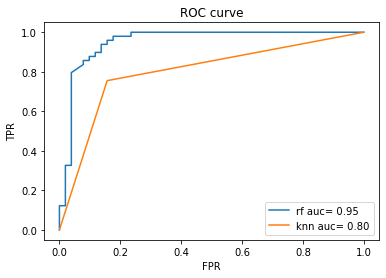

In [87]:
import matplotlib.pyplot as plt
plt.plot(rfrocfpr,rfroctpr,label=f'rf auc= {rfauc:.2f}')
plt.plot(knnrocfpr,knnroctpr,label=f'knn auc= {knnauc:.2f}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend()

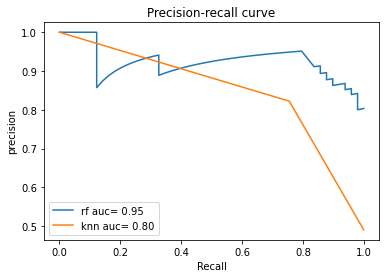

In [ ]:

plt.plot(rfrecall,rfprecision,label=f'rf auc= {rfauc:.2f}')
plt.plot(knnrecall,knnprecision,label=f'knn auc= {knnauc:.2f}')
plt.xlabel('Recall')
plt.ylabel('precision')
plt.title('Precision-recall curve')
plt.legend()

**Your answers to the above questions:**

ROC is suitable for balanced datasets and PR curve is suitable for imbalanced curves. The ham-spam ratio in this dataset is 0.3, which is imbalanced. So using PR curve is better. Random forest is better, because it has higher AUC.

# Part 2: Representation Learning [40 points]

Before getting started, please put the attached file `pretrained_convnet.pt` in the same directory as this notebook.

Recall from lecture the "crumpled paper analogy": in a neural net, as you progress through the layers from input to output, the layers should be "unfolding the original space" to disentangle the classes. When you get to the layer before the classifier, you should've changed the data representation into something that makes classification easy. **We will refer to the layer before the classifier in the neural net as the bottleneck layer.**

In this problem, you will be using an output of a bottleneck layer from pre-trained CNN as input features for a few simple classifiers. The CNN provided was trained with the Fashion MNIST dataset which consists of 10 classes of 28x28 grayscale images; this dataset is very similar to MNIST in that there are 10 classes with images that are the same size as MNIST and in fact even the training and test set sizes are the same (60,000 and 10,000 respectively). However, the classes are not the digits 0 through 9. Instead the classes are:

| Class | Description |
| ----- | :---------: |
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Let's start with some imports.

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummaryX import summary

from UDA_pytorch_utils import UDA_pytorch_classifier_fit, \
        UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
        UDA_pytorch_model_transform, UDA_compute_accuracy

**Loading in the data.** We first load the Fashion MNIST dataset and plot some example images.

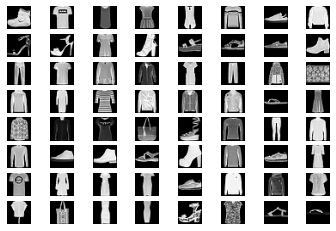

In [ ]:
# do not modify this cell
train_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                  train=True,
                                                  transform=transforms.ToTensor(),
                                                  download=True)

train_images = torch.tensor([image.numpy() for image, label in train_dataset])
train_labels = torch.tensor([label for image, label in train_dataset])

test_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                 train=False,
                                                 transform=transforms.ToTensor(),
                                                 download=True)

test_images = torch.tensor([image.numpy() for image, label in test_dataset])
test_labels = torch.tensor([label for image, label in test_dataset])

# show some of the first training images
square_grid_num_rows = 8
num_images_to_show = square_grid_num_rows ** 2
for idx in range(num_images_to_show):
    plt.subplot(square_grid_num_rows, square_grid_num_rows, idx + 1)
    plt.imshow(train_images[idx][0], cmap='gray')
    plt.axis('off')

**(a) [5 points]** Select train and test data that belong to classes 2 (corresponding to pullovers) or 6 (corresponding to fancier shirts than t-shirts; note: class 0 corresponds to t-shirts), i.e., subsample all the data that has label 2 or 6. Save the variables as `x_train`, `x_test`, `y_train`, `y_test`. From now on, we are only dealing with the images that are in classes 2 (pullovers) or 6 (shirts). Moreover, in `y_train` and `y_test`, please renumber the two classes so that pullovers now instead corresponds to 0 and shirts corresponds to 1 (we will consider shirts to be the "positive" class and pullovers to be the "negative" class).

In [ ]:
# write your code here
train_index=np.where((train_labels==2) | (train_labels==6) )
x_train = train_images[train_index]
y_train = train_labels[train_index]
y_train[y_train==2]=0
y_train[y_train==6]=1
test_index=np.where((test_labels==2) | (test_labels==6) )
x_test = test_images[test_index]
y_test = test_labels[test_index]
y_test[y_test==2]=0
y_test[y_test==6]=1

In [ ]:
x_test.shape

torch.Size([2000, 1, 28, 28])

In [ ]:
# do not modify this cell
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([12000, 1, 28, 28]) torch.Size([12000])
torch.Size([2000, 1, 28, 28]) torch.Size([2000])


We will make some t-SNE visualizations shortly and using all the training data will be too slow. We reduce the size of the training dataset by randomly subsampling 1000 samples from `x_train`/`y_train` pairs and saving the subsampled versions as `x_train_small`/`y_train_small` (the i-th image in `x_train_small` should have its label given by the i-th entry in `y_train_small`). We have provided the indices of which 1000 samples to use (from within `x_train`/`y_train`).

In [ ]:
# do not modify this cell
np.random.seed(0)
random_sample = np.random.permutation(len(x_train))[:1000]

In [ ]:
# write your code here
x_train_small=x_train[random_sample]
y_train_small=y_train[random_sample]

**(b) [9 points]** We are ready to load the pre-trained convnet. The bottleneck layer is right before the final linear layer and corresponds to the output of a ReLU that has 84 values. **We refer to the output of this ReLU as the bottleneck feature vector representation of whatever the input is.**

Note that the convnet was pre-trained using the entire training dataset which consists of 60,000 samples and all 10 labels.

In [ ]:
# load the pre-trained CNN
convnet = nn.Sequential(nn.Conv2d(1, 6, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Conv2d(6, 16, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Flatten(),
                        nn.Linear(in_features=16 * 5 * 5, out_features=120),
                        nn.ReLU(),
                        nn.Linear(in_features=120, out_features=84),
                        nn.ReLU(),
                        nn.Linear(in_features=84, out_features=10))
convnet.load_state_dict(torch.load('pretrained_convnet.pt'))
convnet.eval()
print('[Summary of pre-trained convnet]')
summary(convnet, torch.zeros((1, 1, 28, 28)))
print()

# select the pretrained CNN upto the bottleneck layer
intermediate_layer_model = convnet[:-1]
print('[Summary of the pre-trained convnet up to the bottleneck layer]')
summary(intermediate_layer_model, torch.zeros((1, 1, 28, 28)))

[Summary of pre-trained convnet]
        Kernel Shape     Output Shape   Params Mult-Adds
Layer                                                   
0_0     [1, 6, 3, 3]   [1, 6, 26, 26]     60.0   36.504k
1_1                -   [1, 6, 26, 26]        -         -
2_2                -   [1, 6, 13, 13]        -         -
3_3    [6, 16, 3, 3]  [1, 16, 11, 11]    880.0  104.544k
4_4                -  [1, 16, 11, 11]        -         -
5_5                -    [1, 16, 5, 5]        -         -
6_6                -         [1, 400]        -         -
7_7       [400, 120]         [1, 120]   48.12k     48.0k
8_8                -         [1, 120]        -         -
9_9        [120, 84]          [1, 84]  10.164k    10.08k
10_10              -          [1, 84]        -         -
11_11       [84, 10]          [1, 10]    850.0     840.0
---------------------------------------------------------
                        Totals
Total params           60.074k
Trainable params       60.074k
Non-trainable para

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_0,"[1, 6, 3, 3]","[1, 6, 26, 26]",60.0,36504.0
1_1,-,"[1, 6, 26, 26]",NaN,NaN
2_2,-,"[1, 6, 13, 13]",NaN,NaN
3_3,"[6, 16, 3, 3]","[1, 16, 11, 11]",880.0,104544.0
4_4,-,"[1, 16, 11, 11]",NaN,NaN
5_5,-,"[1, 16, 5, 5]",NaN,NaN
6_6,-,"[1, 400]",NaN,NaN
7_7,"[400, 120]","[1, 120]",48120.0,48000.0
8_8,-,"[1, 120]",NaN,NaN


We first extract bottleneck feature vectors of the subsampled 1000 training data from the intermediate model.

In [ ]:
# do not modify this cell
x_train_small_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_train_small)

Next, visualize two different types of features with t-SNE.

1. Make a t-SNE plot using the **784 (=28$\times$28) dimensional raw features** from the subsampled training data (i.e., using `x_train_small`). Set `n_components=2, verbose=1, perplexity=25, random_state=0` for `TSNE` from scikit-learn. Plot the two classes in different colors.

2. Repeat the previous step (using the exact same arguments for `TSNE`) except now using the **84 dimensional bottleneck features** (i.e., using `x_train_small_bottleneck_representation`.

You may need to convert between PyTorch tensors and NumPy arrays.

In [ ]:
# write your code here
x_train_small_bottleneck_representation.shape

torch.Size([1000, 84])

In [ ]:
x_train_small.shape

torch.Size([1000, 1, 28, 28])

In [ ]:
len(x_train_small)

1000

In [ ]:

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,verbose=1, perplexity=25, random_state=0)
tsne_res=tsne.fit_transform(x_train_small.reshape(len(x_train_small),-1))
tsne_res.shape

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.051s...
[t-SNE] Computed neighbors for 1000 samples in 1.600s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.929498
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.154640
[t-SNE] KL divergence after 1000 iterations: 1.066530


(1000, 2)

In [ ]:
tsne_res

array([[-40.056606  ,  19.579802  ],
       [ 10.47989   ,  -7.7919273 ],
       [ 27.242466  ,   2.0550318 ],
       ...,
       [-14.111373  ,   1.9924562 ],
       [  0.74748653,  12.417704  ],
       [  0.82332563,  20.184069  ]], dtype=float32)

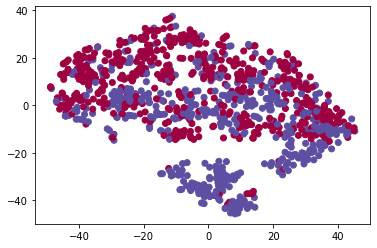

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(tsne_res[:,0],tsne_res[:,1],c=y_train_small,cmap='Spectral')


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.008s...
[t-SNE] Computed neighbors for 1000 samples in 0.163s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.053075
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.166046
[t-SNE] KL divergence after 1000 iterations: 0.992456


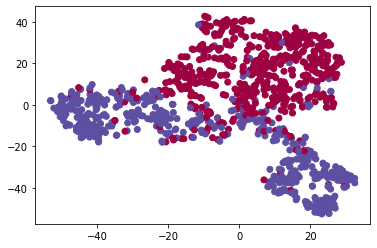

In [ ]:
tsne_res2=tsne.fit_transform(x_train_small_bottleneck_representation.cpu())
plt.scatter(tsne_res2[:,0],tsne_res2[:,1],c=y_train_small,cmap='Spectral')

**(c) [16 points]** We now evaluate on test data and compare several different classifiers. Train **5-NN** and **random forest** classifiers with **784 (=28$\times$28) raw features** and, separately, the **84 bottleneck features** from **all training data**, respectively. That means you should train 4 models in total:

1. 5-NN classifier trained on all raw training features
2. 5-NN classifier trained on all training bottleneck features
3. Random forest trained on all raw training features (for reproducibility of code, please use arguments `n_estimators=100, random_state=0` for `RandomForestClassifier`)
4. Random forest trained on all training bottleneck features (again, use `n_estimators=100, random_state=0`)

Test each model with corresponding **test dataset** and print the test accuracy. Also, compute and print the test accuracy of the **pre-trained convnet** (`convnet`) by using **test data**. You may think of this task as filling in the blanks of the following table with test accuracy results.

| Model type       | Raw features        | Bottleneck features  |
|:---------------- |:-------------------:|:--------------------:|
| Pretrained CNN   |          0.891           | this cell stays empty|
| 5-NN             |          0.856           |        0.888              |
| Random forest    |          0.8765           |         0.898             |

Important: the pre-trained convnet is for all 10 classes; only look at the probabilities corresponding to pullovers (class 2) and shirts (class 6), and take an argmax only over these two class probabilities to come up with predictions stricted to pullovers or shirts.

In [ ]:
x_train.shape

torch.Size([12000, 1, 28, 28])

In [ ]:
UDA_pytorch_model_transform(intermediate_layer_model, x_train_small)

In [ ]:
# write your code here
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
knnclass1=KNeighborsClassifier(n_neighbors=5)
knnclass1.fit(x_train.reshape(len(x_train),-1),y_train)
knn1_predict=knnclass1.predict(x_test.reshape(len(x_test),-1))
knn1_ac=accuracy_score(y_test,knn1_predict)
knn1_ac

0.856

In [ ]:
knnbottle_train=UDA_pytorch_model_transform(intermediate_layer_model, x_train).cpu()
knnclass2=KNeighborsClassifier(n_neighbors=5)
knnclass2.fit(knnbottle_train,y_train)
test_bottle=UDA_pytorch_model_transform(intermediate_layer_model, x_test).cpu()
knn2_predict=knnclass2.predict(test_bottle)
knn2_ac=accuracy_score(y_test,knn2_predict)
knn2_ac

0.888

In [ ]:
pretrain_res=UDA_pytorch_model_transform(convnet,x_test).cpu()
pretrain_res2=pretrain_res[:,[2,6]].argmax(axis=1)

In [ ]:
pretrain_res2[np.where(pretrain_res2==2)]=0
pretrain_res2[np.where(pretrain_res2==6)]=1
accuracy_score(y_test,pretrain_res2)

0.891

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_class1=RandomForestClassifier(n_estimators=100, random_state=0)
rf_class1.fit(x_train.reshape(len(x_train),-1),y_train)
rf1_predict=rf_class1.predict(x_test.reshape(len(x_test),-1))
rf1_ac=UDA_compute_accuracy(y_test,rf1_predict)
rf1_ac

0.8765

In [ ]:
rfbottle_train=UDA_pytorch_model_transform(intermediate_layer_model, x_train).cpu()


rf_class2=RandomForestClassifier(n_estimators=100, random_state=0)
rf_class2.fit(rfbottle_train,y_train)
rftest_bottle=UDA_pytorch_model_transform(intermediate_layer_model, x_test).cpu()
rf2_predict=rf_class2.predict(rftest_bottle)
rf2_ac=UDA_compute_accuracy(y_test,rf2_predict)
rf2_ac


0.898

In [ ]:
np.mean(y_test.numpy()==rf2_predict)

0.898

Among the five models above, which model performed the best? Which model showed the lowest accuracy? For the 5-NN and random forest classifiers, is the prediction accuracy higher using bottleneck features instead of the raw features?

**Write your answers here:**

Random forest with bottleneck features perform the best. Pretrained CNN performed the wrost. Yes, using bottleneck features brings higher accuracies.

**(d) [10 points]** We now look at plotting an ROC curve, varying $k$ in $k$-NN. Train k-NN classifiers with $k=1,2,...,50$ with **bottleneck** feature vectors of all **training** data. As a result, you will get 50 classifiers. Draw a scatter plot that has false positive rate (FPR) on x-axis and true positive rate (TPR) on y-axis. Each scatter point represents one k-NN classifier. Use the **test** data to compute FPR and TPR.

Recall that true and false positive rate calculations require you to specify one of the two outcomes as the "positive" class and the other as the "negative" class. For this problem, use class 6 (shirts) as the "positive" class, and class 2 (pullovers) as the "negative" class.

In [ ]:
# write your code here
import numpy as np
bottle_train_2d=UDA_pytorch_model_transform(intermediate_layer_model, x_train).cpu()
test_bottle_2d=UDA_pytorch_model_transform(intermediate_layer_model, x_test).cpu()
tpr_list=[]
fpr_list=[]
for i in range(50):
    classifier = KNeighborsClassifier(n_neighbors=i+1)
    classifier.fit(bottle_train_2d, y_train)
    predicted_val_labels = classifier.predict(test_bottle_2d)
    tp=[1 for i in range(len(y_test)) if y_test[i]==predicted_val_labels[i] and predicted_val_labels[i]==1 ]
    fn=[1 for i in range(len(y_test)) if y_test[i]!=predicted_val_labels[i] and predicted_val_labels[i]==0 ]
    fp=[1 for i in range(len(y_test)) if y_test[i]!=predicted_val_labels[i] and predicted_val_labels[i]==1 ]
    tn=[1 for i in range(len(y_test)) if y_test[i]==predicted_val_labels[i] and predicted_val_labels[i]==0 ]
    tp=np.array(tp).sum()
    fn=np.array(fn).sum()
    fp=np.array(fp).sum()
    tn=np.array(tn).sum()
    tpr= tp/(tp+fn)
    fpr=fp/(fp+tn)
    tpr_list.append(tpr)
    fpr_list.append(fpr)


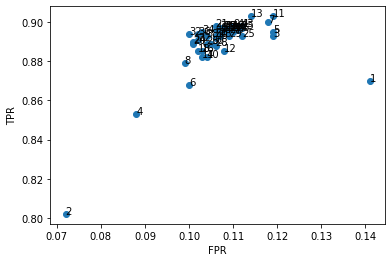

In [ ]:
fig, ax = plt.subplots()
ax.scatter(fpr_list,tpr_list)
plt.xlabel('FPR')
plt.ylabel('TPR')
# plt.legend()
for i in range(50):
    ax.annotate(i+1, (fpr_list[i], tpr_list[i]))

Suppose you work for a company that wants to figure out when a shirt appears among photos that have either shirts or pullovers. The company tells you that it cannot tolerate a false positive rate of detecting shirts that is more than 12.5%. What value of number of nearest neighbors $k$ achieves the highest true positive rate, but doesn't have more than a 12.5% false positive rate?

**Write your answer here:**

11

In [ ]:
# write your code here (if it helps you justify your answer above)
tprmax=-np.inf
maxindex=-1
for i in range(50):
    if fpr_list[i]<0.125:

        if tpr_list[i]>tprmax:
            tprmax=tpr_list[i]
            maxindex=i+1
print(maxindex)

11


# Part 3: Sentiment Analysis [40 points]

Download data from: http://www.andrew.cmu.edu/user/georgech/HW3-data.zip <br>

The folder contains:

- `train.csv`
- `test.csv`

In this problem, we look at predicting whether a tweet has positive or negative sentiment.

**We intentionally wrote this problem to be a bit open-ended to let you play with different neural net code yourself and also for you to compare against a classical baseline.** We will give full credit even if you subsample the training data. For example, you only work with 5000 randomly chosen training tweets instead of all of them (over 1 million tweets). Also, for the random forest part (the last part), you can keep track of only the most frequently occurring 1000 words (again, this is enough for full credit) and you can also set the RandomForestClassifier argument "n_jobs" to -1 to use all your CPU threads. However, do not subsample the test dataset (which is small anyways).

If you want to have practice with what it's like working with a sizable dataset though, we do encourage you to try to use as much of the training data as possible (our solution code uses the full training data in an 80-20 split between a proper training set and a validation set, just like in lectures). Note that using all the data does involve more careful data preprocessing to avoid possible memory issues. Some suggestions:

- Using your knowledge from weeks 1 and 2, you can write your own code to tokenize tweets and only include some of the tokens (e.g., only keeping the most common 1000 tokens, etc); in particular you can build your own vocabulary. As a suggestion, make vocabulary token \#0 correspond to a special padding character `"<pad>"`; this special index 0 will in fact be automatically added by the batching process for recurrent neural nets when making different tweets within the same batch have the same length. As another suggestion, make a special vocabulary token `"<unk>"` for unknown tokens that you've decided not to keep track of. For example, if you only keep track of the most common 1000 tokens, then any token that is not one of these most common 1000 gets represented as `"<unk>"`.

- For the last part, training a random forest for sentiment analysis could be very computationally expensive. If you are already subsampling the training data beforehand, then great, just work with a smaller dataset (note: you should use the same training data for both the LSTM and for the random forest so that the comparison between them is fair). If you want to still try to use the full training dataset or as much of it as possible, then we suggest that you represent the feature vectors as a sparse matrix. You might also want to set the "max_samples" argument to be something like 0.1 so that each tree uses a 10% subsample of the proper training set (with the default choice of 100 trees, across all your trees, you will likely use the vast majority of the full training set---it's just that each tree won't look at more than 10% of the proper training set). Also, simple data splitting suffices; cross-validation here would be very expensive. Moreover, it's fine to not train a random forest from scratch using the best hyperparameters found; instead just use whichever model was trained using the proper training data with the best hyperparameters found.

**(a) [5 points]** We first read in the tweet data. Read the data present in `train.csv` file. **Please do not change the filename. In particular, use a relative path, i.e., `./HW3-data/train.csv`**. Then do the following:

1. Keep only the sentiment and sentiment text in the data - the first and the last coumn
2. Print the number of positive and negative sentiment labels

Note: If you are using `open()`, you may have to set `encoding='iso8859'`.

In [2]:
# your code here
import numpy as np
train=[]
with open('train.csv',encoding='iso8859') as f:
    for line in f:
        train.append(line.strip())
len(train)
train2 = [ [line.split(',')[0],line.split(',')[-1]] for line in train]
train3 = np.array(train2)
neglen=np.count_nonzero(train3[:,0]=='0')
poslen=np.count_nonzero(train3[:,0]=='1')
print("negative label: "+str(neglen)+"positive label: "+str(poslen))

negative label: 800000positive label: 800000


In [3]:
index = np.random.permutation(len(train3))
train4=train3[index[:5000]]
train4.shape

(5000, 2)

**(b) [25 points]** Modify the LSTM demo code from lecture to work with this Twitter dataset. Play with the learning rate and batch size so that the training gives reasonable increases in training and validation accuracies as we progress through epochs (leave the number of epochs at 10). Also feel free to try different neural net architectures (although you do not have to). What test accuracy are you able to achieve?

Epoch 1 [==================================================] 4000/4000
  Train accuracy: 0.5048
  Validation accuracy: 0.5100
Epoch 2 [==================================================] 4000/4000
  Train accuracy: 0.5158
  Validation accuracy: 0.5310
Epoch 3 [==================================================] 4000/4000
  Train accuracy: 0.5647
  Validation accuracy: 0.5600
Epoch 4 [==================================================] 4000/4000
  Train accuracy: 0.6730
  Validation accuracy: 0.6560
Epoch 5 [==================================================] 4000/4000
  Train accuracy: 0.6610
  Validation accuracy: 0.6110
Epoch 6 [==================================================] 4000/4000
  Train accuracy: 0.6380
  Validation accuracy: 0.5980
Epoch 7 [==================================================] 4000/4000
  Train accuracy: 0.7037
  Validation accuracy: 0.6450
Epoch 8 [==================================================] 4000/4000
  Train accuracy: 0.7133
  Validation accuracy:

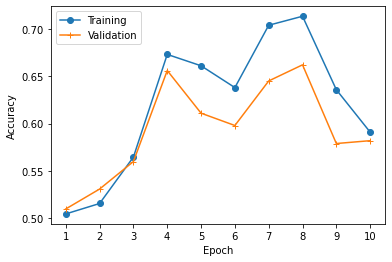

In [94]:
import torch
proper_train_size = int(len(train4) * 0.8)
val_size = len(train4) - proper_train_size
proper_train_dataset, val_dataset = torch.utils.data.random_split(train4,
                                                                  [proper_train_size,
                                                                   val_size])
from torchnlp.encoders.text import SpacyEncoder
encoder = SpacyEncoder([str(data[1]) for data in proper_train_dataset])
proper_train_encoded = [encoder.encode(str(data[1])) for data in proper_train_dataset]
proper_train_labels = torch.tensor([int(data[0]) for data in proper_train_dataset])
val_encoded = [encoder.encode(str(data[1])) for data in val_dataset]
val_labels = torch.tensor([int(data[0]) for data in val_dataset])
proper_train_dataset_encoded = list(zip(proper_train_encoded, proper_train_labels))
val_dataset_encoded = list(zip(val_encoded, val_labels))
train4
# train_c = [encoder.encode(str(i[1])) for i in train4]
# train_label_c= torch.tensor([int(data[0]) for data in train4])
# [ data[1] for data in train4 ]
train_c =[encoder.encode(str(i[1])) for i in train4]
train_encoded_c =[]
train_label_c=torch.tensor([int(data[0]) for data in train4])
train_label_c


from torchnlp.word_to_vector import GloVe
pretrained_embedding = GloVe(name='6B', dim=100)
embedding_weights = torch.Tensor(encoder.vocab_size, pretrained_embedding.dim)
for i, token in enumerate(encoder.vocab):
    embedding_weights[i] = pretrained_embedding[token]


import matplotlib.pyplot as plt
import numpy as np

# the next two lines are needed on my Intel-based MacBook Air to get the code to run; you likely don't need these two lines...
# (in fact I used to not need these two lines)
import os

import torch
import torch.nn as nn
from torchsummaryX import summary

from UDA_pytorch_utils import UDA_LSTMforSequential, UDA_pytorch_classifier_fit, \
    UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
    UDA_compute_accuracy
simple_lstm_model = nn.Sequential(nn.Embedding.from_pretrained(embedding_weights),
                                  UDA_LSTMforSequential(100, 64),
                                  nn.Linear(64, 2))


num_epochs = 10  # during optimization, how many times we look at training data
batch_size = 100  # during optimization, how many training data to use at each step
learning_rate = 0.001  # during optimization, how much we nudge our solution at each step

train_accuracies, val_accuracies = \
    UDA_pytorch_classifier_fit(simple_lstm_model,
                               torch.optim.Adam(simple_lstm_model.parameters(),
                                                lr=learning_rate),
                               nn.CrossEntropyLoss(),  # includes softmax
                               proper_train_dataset_encoded, val_dataset_encoded,
                               num_epochs, batch_size,
                               sequence=True)

UDA_plot_train_val_accuracy_vs_epoch(train_accuracies, val_accuracies)

In [95]:
test=[]
with open('test.csv',encoding='iso8859') as f:
    for line in f:
        test.append(line.strip())
test2 = [ [line.split(',')[0],line.split(',')[-1]] for line in test]

test_encoded = [encoder.encode(data[1]) for data in test2]
test_labels = torch.tensor([int(data[0]) for data in test2])
predicted_test_labels = UDA_pytorch_classifier_predict(simple_lstm_model,
                                                       test_encoded,
                                                       sequence=True)
print('Test accuracy:', UDA_compute_accuracy(predicted_test_labels, test_labels))

Test accuracy: 0.42369477911646586


**(c) [10 points]** How well does an LSTM compare with using a classical classifier? To investigate this question, let's try training a random forest for sentiment analysis. Your code from part **(b)** should involve coming up with encoded representations of text, i.e., representing a tweet using a sequence of word indices. Use this to come up with a term frequency representation for each tweet. Feel free to remove stop words and/or apply TF-IDF weighting, and then feed the resulting feature vector representations for tweets to a random forest classifier. You can use cross-validation to select hyperparameters. Try to make the random forest classifier perform as well as possible (it is good practice in real-world applications to try to make baselines as good as possible rather than intentionally using a baseline with lousy hyperparameter choices; in particular, it is *bad* practice to tune hyperparameters carefully only on a method you're proposing while not tuning hyperparameters on baselines!). What test set accuracy are you able to achieve with the random forest?

In [14]:
# your code here
stop =[]
with open('stopwords.txt') as f:
    for line in f:
        stop.append(line.strip())
        
pre_train_c=[ j for i in train4 for j in str(i[1]).split() if j not in stop]
pre_train_c=[]
for i in train4:
    tmp =[]
    for j in str(i[1]).split():
        if j not in stop:
            tmp.append(j)
    pre_train_c.append(' '.join(tmp))
train_c =[encoder.encode(str(i)) for i in pre_train_c]
train_label_c=torch.tensor([int(data[0]) for data in train4])
train_label_c

tensor([0, 1, 0,  ..., 1, 1, 1])

In [66]:
train_c_all =np.ones((len(train_c),encoder.vocab_size))
for iindex,i in enumerate(train_c):
    for j in i:
        train_c_all[iindex,j.numpy()]+=1
train_c_all=[ i/i.sum() for i in train_c_all]

In [67]:
pre_test_c=[]
for i in test2:
    tmp =[]
    for j in str(i[1]).split():
        if j not in stop:
            tmp.append(j)
    pre_test_c.append(' '.join(tmp))
test_c =[encoder.encode(str(i)) for i in pre_test_c]
test_labels = torch.tensor([int(data[0]) for data in test2])
# maxlen_test=max([len(i) for i in test_c])
# test_c_57=[]
# for i in test_c:
#     tmp=[]
#     for j in i:
#         tmp.append(j.numpy())
#     while(len(tmp)< maxlen):
#         tmp.append(0)
#   # print(tmp)
#     test_c_57.append(np.array(tmp))
# test_c_57=np.array(test_c_57)
# test_c_57.shape
test_c_all =np.ones((len(test_c),encoder.vocab_size))
for iindex,i in enumerate(test_c):
    for j in i:
        test_c_all[iindex,j.numpy()]+=1
test_c_all=[ i/i.sum() for i in test_c_all]

In [69]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
kf = KFold(n_splits=2,shuffle=True,random_state=0)
train_c_all=np.array(train_c_all)
num_features = train_c_all.shape[1]
hyperparameter_settings = [(max_features, min_samples_leaf)
                           for max_features in [int(np.ceil(np.sqrt(num_features) / 4)),
                                                int(np.ceil(np.sqrt(num_features))),
                                                int(np.ceil(np.sqrt(num_features) * 4))]
                           for min_samples_leaf in [1, 2, 4, 8]]

# fill this with hyperparameter settings that you want to try
import numpy as np
from sklearn.metrics import f1_score
train=train_c_all
label=train_label_c
best_hyperparam_setting = None
best_cross_val_score = -np.inf  # assumes that a higher score is better
k_fold = KFold(n_splits=2,shuffle=True,random_state=0)
# label=np.array(label_list)
# train=countvec_res.toarray()

for hyperparam_setting in hyperparameter_settings:
    max_features, min_samples_leaf = hyperparam_setting
    fold_scores = []
    # your code to train and score the training data here
    for train_index,val_index in k_fold.split(train):
        # print(train_index)
        # print(train)
        # print(train.[[0,1]])
        proper_train_features = train[train_index]
        proper_train_labels = label[train_index]
        val_features = train[val_index]
        val_labels = label[val_index]
        
        classifier = RandomForestClassifier(max_features=max_features,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=0)
        # print(np.array(proper_train_features))
        # print(proper_train_labels.numpy())
        classifier.fit(proper_train_features, proper_train_labels.numpy())
        predicted_val_labels = classifier.predict(val_features)
        
        fold_scores.append(f1_score(val_labels,predicted_val_labels,average='weighted'))
    
    cross_val_score = np.mean(fold_scores)
    print(cross_val_score)
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_hyperparam_setting = hyperparam_setting

print('Best hyperparameter setting for RF:', best_hyperparam_setting)

0.6697456961689506
0.563248328907118
0.36354521876079365
0.3258286582479658
0.6494814304164449
0.6661746427167492
0.6394423427992455
0.4918076739439291
0.6415720513136415
0.6542389154003433
0.6366917298752298
0.6211415487611027
Best hyperparameter setting for RF: (25, 1)


In [70]:
max_features=25
min_samples_leaf=1
rfclassifier = RandomForestClassifier(max_features=max_features,min_samples_leaf=min_samples_leaf,random_state=0)
rfclassifier.fit(train_c_all, train_label_c)
rfpredicted_val_labels = classifier.predict(test_c_all)
UDA_compute_accuracy(rfpredicted_val_labels,test_labels.numpy())

0.6265060240963856